In [44]:
import numpy as np
import tsplib95
from python_tsp.distances.tsplib_distance import tsplib_distance_matrix

dataset = "data/xqf131.tsp"

cities = np.atleast_2d(list(tsplib95.load(dataset).node_coords.values()))
distance_matrix = tsplib_distance_matrix(dataset)


In [45]:
from math import dist

distances = []
for i, p1 in enumerate(cities):
    for j, p2 in enumerate(cities):
        if i != j:
            distances.append(dist(p1, p2))
print(np.mean(distances))

35.50795393951274


In [46]:
from sklearn.cluster import KMeans

N_CLUSTERS = 8

kmeans = KMeans(n_clusters=N_CLUSTERS).fit(cities)
print(kmeans.labels_)

LABELS = np.atleast_1d(kmeans.labels_)
CENTROIDS = np.atleast_2d(kmeans.cluster_centers_)

[6 7 7 7 6 6 6 7 7 7 7 6 6 6 6 6 6 6 6 1 1 7 7 7 6 6 1 1 1 1 1 1 1 1 1 7 7
 7 7 7 7 7 7 7 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 2 5 5 5 2 5 5 5 5 5 2
 2 5 2 2 5 5 2 2 5 5 5 5 2 2 2 3 3 2 2 2 3 3 3 0 0 0 0 0 3 3 0 0 0 0 4 4 4
 0 0 0 4 4 4 0 4 4 0 4 0 0 0 4 4 4 4 0 4]


In [47]:
import matplotlib.pyplot as plt

def plot_initial_clusters(points, kmeans, centroids):
    # reduced_data = PCA(n_components=2).fit_transform(data)
    # kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
    # kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.01  # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
    y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    plt.plot(points[:, 0], points[:, 1], "k.", markersize=2)
    # Plot the centroids as a white X

    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )

    for idx, c in enumerate(centroids):
        plt.annotate(idx, c, fontsize = 30)

    plt.title(
        "K-means clustering\n"
        "Centroids are marked with white cross"
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

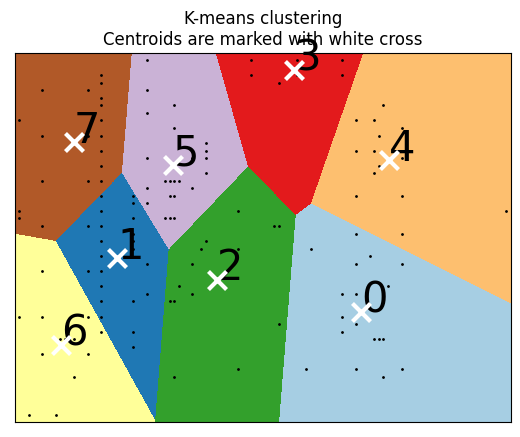

In [48]:
plot_initial_clusters(cities, kmeans, CENTROIDS)

In [49]:
from python_tsp.distances.euclidean_distance import euclidean_distance_matrix
from python_tsp.heuristics.local_search import solve_tsp_local_search
from python_tsp.exact.dynamic_programming import solve_tsp_dynamic_programming
from python_tsp.exact.brute_force import solve_tsp_brute_force

subproblems = []

for i in range(N_CLUSTERS):
    problem = np.atleast_2d([city for idx, city in enumerate(cities) if kmeans.labels_[idx] == i])
    subproblems.append(problem)

CLUSTERS = []
for p in subproblems:
    distance_matrix = euclidean_distance_matrix(p)
    permutation, distance = solve_tsp_local_search(distance_matrix)
    print(distance)
    subset = np.atleast_2d([p[x] for x in permutation])
    # print(subset)
    CLUSTERS.append(subset)


97.89851688161114
64.04118923485889
83.8604636830193
44.20586815591588
101.5021774646351
66.22371976732668
68.17192964312683
83.33510351081367


In [50]:
from math import dist

for c in CLUSTERS:
    distances = []
    for i, p1 in enumerate(c):
        for j, p2 in enumerate(c):
            if i != j:
                distances.append(dist(p1, p2))
    print(np.mean(distances))

10.862692053587075
9.324890588943424
14.178726244916032
10.345677171073126
10.939328142182402
9.010736864494529
9.267716643359133
12.102919427589901


In [51]:
from math import dist

def plot_clusters(points, clusters, centroids, cp=None):
    
    x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
    y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1

    plt.plot(points[:, 0], points[:, 1], "k.", markersize=2)

    for cluster in clusters:
        for i in range(len(cluster) - 1):
            plt.plot(cluster[[i, i+1], 0], cluster[[i, i+1], 1], c="k")
        plt.plot(cluster[[len(cluster) - 1, 0], 0], cluster[[len(cluster) - 1, 0], 1], c="k")

    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="k",
        zorder=10,
    )

    if cp:
        for idx, p in enumerate(cp):
            plt.plot(
                p[0],
                p[1],
                "bo"
            )
            plt.annotate(
                text=idx + 1,
                xy=p,
            )

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

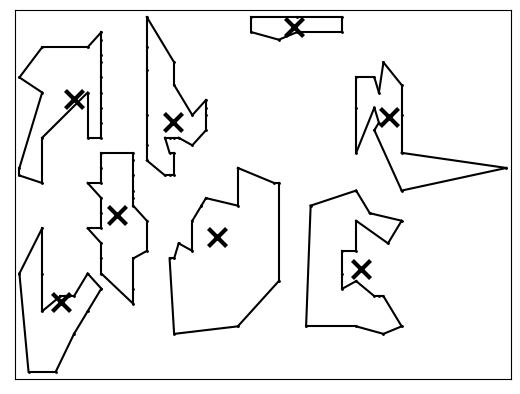

In [52]:
plot_clusters(cities, CLUSTERS, CENTROIDS)

In [53]:
def concatenate_clusters(cluster_a: np.ndarray, cluster_b: np.ndarray, centroid_a: np.ndarray, centroid_b: np.ndarray) -> (np.ndarray, np.ndarray):
    
    def get_closest_points_to_centroid(cluster, centroid):

        distances = []
        for point in cluster:
            distances.append((point, dist(point, centroid)))
        distances.sort(key=lambda x: x[1])
        p1 = distances[0][0]

        idx1 = [idx for idx, x in enumerate(cluster) if x[0] == p1[0] and x[1] == p1[1]][0]

        forward = idx1 + 1
        if forward >= len(cluster):
            forward = 0
        backward = idx1 - 1

        new_perm = list(cluster)

        if dist(cluster[forward], centroid) < dist(cluster[backward], centroid):
            p2 = cluster[forward]
            idx2 = forward
            new_perm = new_perm[idx1::-1] + new_perm[:idx2 - 1:-1]
        else:
            p2 = cluster[backward]
            idx2 = backward
            new_perm = new_perm[idx1:] + new_perm[:idx2 + 1]

        return p1, p2, np.atleast_2d(new_perm)
    
    p1, p2, new_cluster_a = get_closest_points_to_centroid(cluster_a, centroid_b)

    def get_closest_points_to_points(cluster, p1, p2):

        distances = []
        for point in cluster:
            distances.append((point, dist(point, p1)))
        distances.sort(key=lambda x: x[1])
        p3 = distances[0][0]

        distances = []
        for point in cluster:
            if point[0] != p3[0] and point[1] != p3[1]:
                distances.append((point, dist(point, p2)))
        distances.sort(key=lambda x: x[1])
        p4 = distances[0][0]

        idx1 = [idx for idx, x in enumerate(cluster) if x[0] == p3[0] and x[1] == p3[1]][0]

        forward = idx1 + 1
        if forward >= len(cluster):
            forward = 0
        backward = idx1 - 1

        new_perm = list(cluster)

        if dist(cluster[forward], p2) < dist(cluster[backward], p2):
            p4 = cluster[forward]
            idx2 = forward
            new_perm = new_perm[idx1::-1] + new_perm[:idx2 - 1:-1]
        else:
            p4 = cluster[backward]
            idx2 = backward
            new_perm = new_perm[idx1:] + new_perm[:idx2 + 1]

        return p3, p4, np.atleast_2d(new_perm)

    p3, p4, new_cluster_b = get_closest_points_to_points(cluster_b, p1, p2)
    
    result = new_cluster_a

    def ccw(A,B,C):
        return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

    # Return true if line segments AB and CD intersect
    def intersect(A,B,C,D):
        return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

    if intersect(p1, p3, p2, p4):
        result = np.concatenate((result, new_cluster_b), axis=0)
    else:
        result = np.concatenate((result, np.flip(new_cluster_b, 0)), axis=0)

    def get_centeroid(arr):
        x = np.mean(arr[:, 0])
        y = np.mean(arr[:, 1])
        return np.atleast_1d([x, y])
    
    return result, get_centeroid(result), (p1, p2, p3, p4)

In [54]:
def concatenate_all(clusters, centroids):

    t_clusters = list(clusters)
    t_centroids = list(centroids)

    while len(t_clusters) > 1:
        A = 0
        B = 1

        for i in range(1, len(t_centroids)):
            if (dist(t_centroids[i], t_centroids[A]) < dist(t_centroids[B], t_centroids[A])):
                B = i
        # print(A, B)

        new_cluster, new_centroid, cp = concatenate_clusters(t_clusters[A], t_clusters[B], t_centroids[A], t_centroids[B])

        t_clusters = [np.atleast_2d(x) for idx, x in enumerate(t_clusters) if idx != A and idx != B]
        t_centroids = [x for idx, x in enumerate(t_centroids) if idx != A and idx != B]

        t_clusters.append(new_cluster)
        t_centroids.append(new_centroid)
        t_centroids = np.atleast_2d(t_centroids)
        plot_clusters(cities, t_clusters, t_centroids, cp)

    return t_clusters[0], t_centroids[0]

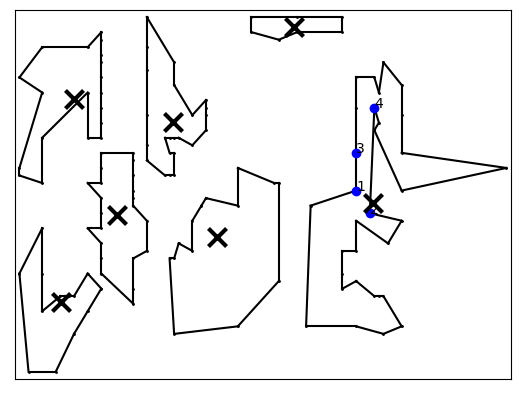

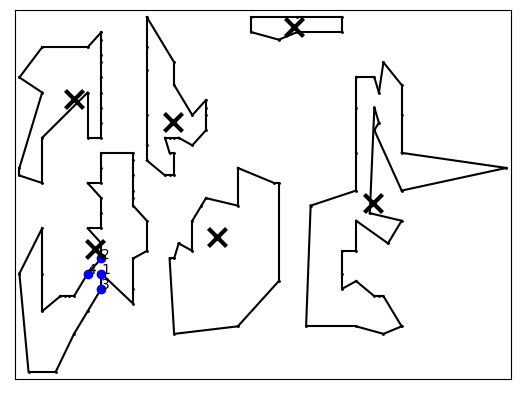

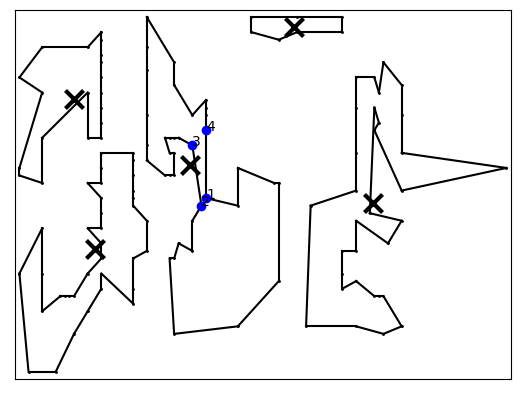

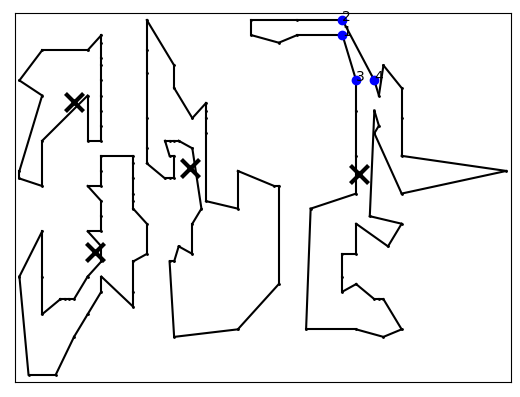

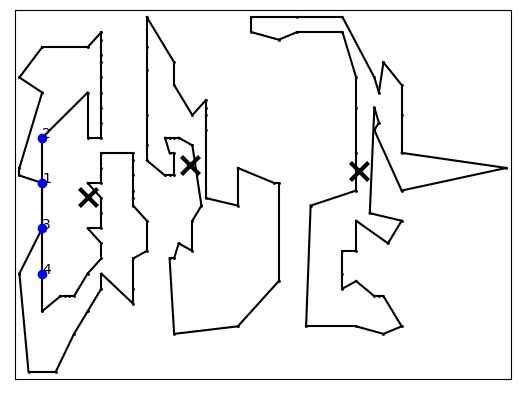

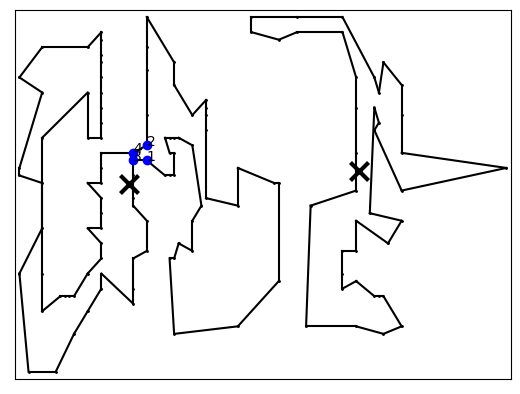

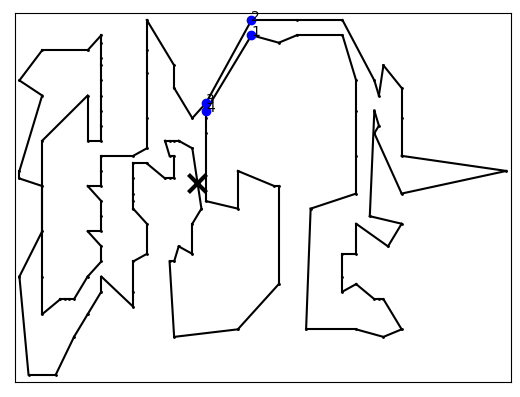

In [55]:
result, centroid = concatenate_all(CLUSTERS, CENTROIDS)

In [56]:
def plot_path(points):
    
    x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
    y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1

    plt.plot(points[:, 0], points[:, 1], "k.", markersize=2)

    for i in range(len(points) - 1):
        plt.plot(points[[i, i+1], 0], points[[i, i+1], 1], c="k")
    plt.plot(points[[len(points) - 1, 0], 0], points[[len(points) - 1, 0], 1], c="k")

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

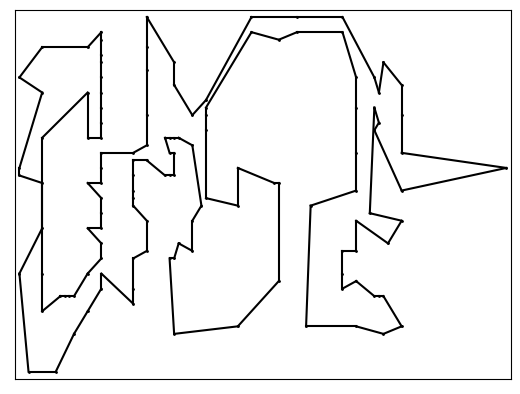

In [57]:
plot_path(result)

In [58]:
cost = 0
for i in range(len(result) - 1):
    cost += dist(result[i], result[i + 1])
cost += dist(result[-1], result[0])
print(cost)

681.5561721407286


In [59]:
perm = [idx for idx, x in enumerate(result)]

In [60]:
distance_matrix = euclidean_distance_matrix(result)

permutation, distance = solve_tsp_local_search(distance_matrix)

print(distance)

629.815469028508


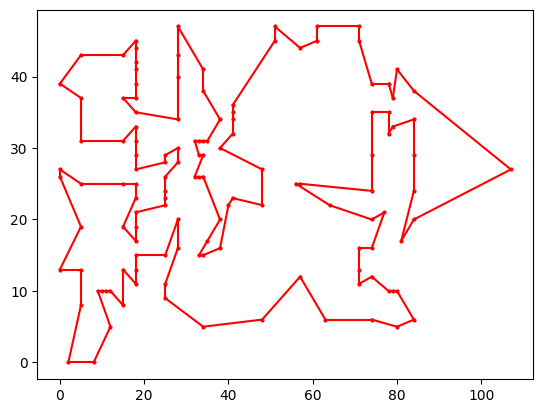

In [61]:
plt.plot(result[:, 0], result[:,1], 'or', markersize=2)

for i in range(len(permutation) - 1):
    plt.plot(result[[permutation[i], permutation[i+1]], 0], result[[permutation[i], permutation[i+1]], 1], c="r")

plt.plot(result[[permutation[len(result) - 1], 0], 0], result[[permutation[len(result) - 1], 0], 1], c="r")

plt.show()

In [62]:
from data.answers import get_answer

perc = distance / get_answer(dataset) * 100 - 100
rounded = np.round((perc) * 1000)
restored = rounded / 1000

print("Final error: {}%".format(restored))

Final error: 11.669%
